In [26]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import constants
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy

from IPython.display import display, Latex

In [29]:
parameters_set = {}


parameters_set["0"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": .5, "joseph_energy_f": 8.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.03}
parameters_set["1"] = {"max_freq_t": 5.0, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": .85, "joseph_energy_f": 5.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.015}

parameters_set["2"] = {"max_freq_t": 4.5, "anharm_t": -0.3, "diel_loss_tan_t": 0.75*1e-6*20,
                     "dephasing_times_t": {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3}, 
                     "charge_energy_f": 1.0, "induct_energy_f": 1.0, "joseph_energy_f": 4.0, 
                     "diel_loss_tan_f": 7.1*1e-6, "dephasing_times_f": {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                                                                        '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3},
                      "jc": 0.02}

In [30]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "2"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times= parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]

In [46]:
def energy_levels_diagram(
    system: QubitSystem,
    levels_to_plot: List[str],
    plot_setup={'fs': 20, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16},
    detuning_tol=3.0,
    show_drive=True
) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    ground_energy = system.state('00')[0]
    energy = {}
    state = {}
    step = 11.0
    level_width = 5.0
    x_avg = {}
    
    for level in levels_to_plot:
        energy[level] = system.state(level)[0] - ground_energy
        state[level] = system.state(level)[1]
    for level in levels_to_plot:
        level_as_list = [int(lev) for lev in level]
        x_min = -0.5 + step*level_as_list[1] - step*level_as_list[0]
        x_max = x_min + level_width
        x_avg[level] = (x_min + x_max)/2
        ax.hlines(y=energy[level], xmin=x_min, xmax=x_max, 
                  linewidth=plot_setup['lw_levels'], color='k')
        ax.text(x_max+0.2, energy[level]-0.05, r'$ \vert' + level + 
                ' \\rangle$', fontsize=plot_setup['fs'], zorder=10)
        ax.tick_params(labelsize=plot_setup['ls'])
        ax.axes.get_xaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    qubit_labels = system.labels
    n1n2_op = system[qubit_labels[0]].charge_op().dot(\
        system[qubit_labels[1]].charge_op())
    abs_mat_elem_vec = np.zeros(len(levels_to_plot)**2)
    count = 0
    for level_1 in levels_to_plot:
        for level_2 in levels_to_plot:
            abs_mat_elem_vec[count] = \
                np.abs(get_mat_elem(n1n2_op, state[level_1], state[level_2]))
            count += 1
    max_abs_mat_elem = np.max(abs_mat_elem_vec)
    for level_1 in levels_to_plot:
        for level_2 in levels_to_plot:
            abs_mat_elem = \
                np.abs(get_mat_elem(n1n2_op, state[level_1], state[level_2]))
            shade_factor = abs_mat_elem/max_abs_mat_elem
            if shade_factor > 1e-4 and np.abs(energy[level_1] - \
                energy[level_2]) < detuning_tol:
                ax.annotate('', (x_avg[level_1], energy[level_1]), \
                            (x_avg[level_2], energy[level_2]), 
                            arrowprops=dict(color='darkorange', 
                            alpha=shade_factor**3, 
                            lw=plot_setup['lw'], arrowstyle='<->'))
                
    if show_drive:
        ax.annotate('', (x_avg['10'], energy['10']), 
                    (x_avg['13'], energy['13']), 
                    arrowprops=dict(color='darkblue', lw=plot_setup['lw'],
                    arrowstyle='<->', linestyle = '--'))
        ax.annotate('', (x_avg['00'], energy['00']), 
                    (x_avg['03'], energy['03']), 
                    arrowprops=dict(color='darkblue', lw=plot_setup['lw'],
                    arrowstyle='<->', linestyle = '--'))
        
    ax.set_title(r'$\mathrm{Transmon} \leftarrow \quad \rightarrow'
                 r'\mathrm{Fluxonium}$', {'fontsize': plot_setup['fs']})
    ax.set_ylabel(r'$\mathrm{Energy} \, (\mathrm{GHz})$', 
                  fontsize=plot_setup['fs'])
    plt.savefig("energy_diagram_trans_flx.svg")
    plt.show()  


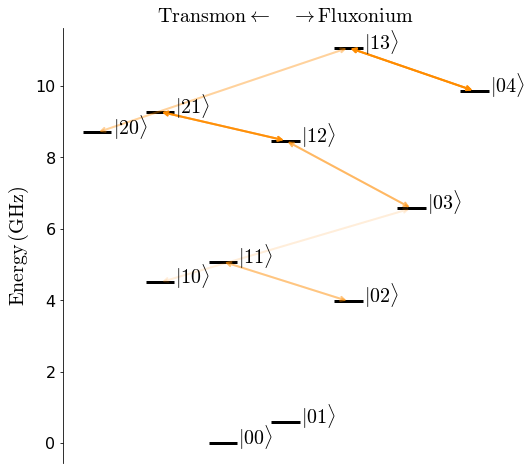

In [47]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

energy_levels_diagram(bare_system, level_list, show_drive=False)

In [33]:
flx_freq

0.5818489963974254

In [28]:
constants.h/(4*constants.elementary_charge**2)

6453.201864826128